# MIRELLA – Notebook 3: Computational analysis for SI

Import experimental data from "RawData_Fig2b.xlsx".

In [1]:
import os
import pandas as pd

imgs_path = os.path.join(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))), 'docs')
data_path = os.path.join(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))), 'data')

df = pd.read_excel(os.path.join(data_path, 'RawData_Fig2b.xlsx')) 

pairing_list = [('A', 'B'), ('E', 'F'), ('G', 'H')]
condition_list = [_ for _ in pd.unique(df['Condition'])]

Preprocessing experimental data

In [2]:
tmp_control_list = []
for condition in condition_list:
    for pair in pairing_list:
        index = ((df['Replicate'] == pair[0]) + (df['Replicate'] == pair[1])) * (df['Condition'] == 'Control')
        tmp_mean_sensor = df[index]['miRNA sensor'].mean(axis=0)
        tmp_mean_monitor = df[index]['Capacity monitor'].mean(axis=0)
        tmp_control_list.extend([{'Condition' : condition, 'Replicate' : j, 'miRNA sensor' : tmp_mean_sensor, 'Capacity monitor' : tmp_mean_monitor} for j in pair])
control_df = pd.DataFrame(tmp_control_list)

replicate_list = [_ for _ in pd.unique(control_df['Replicate'])]
tmp_list = list()
for condition in condition_list:
    for replicate in replicate_list:
        index = (df['Replicate'] == replicate) * (df['Condition'] == condition)
        tmp_norm_sensor = df[index]['miRNA sensor'].tolist()[0] / control_df[control_df['Replicate'] == replicate]['miRNA sensor'].tolist()[0]
        tmp_norm_monitor = df[index]['Capacity monitor'].tolist()[0] / control_df[control_df['Replicate'] == replicate]['Capacity monitor'].tolist()[0]
        tmp_list.append({'Condition' : condition, 'Replicate' : replicate, 'miRNA sensor' : tmp_norm_sensor, 'Capacity monitor' : tmp_norm_monitor})
norm_df = pd.DataFrame(tmp_list)
avg_norm_df = norm_df.groupby(['Condition']).mean()
avg_norm_df = avg_norm_df.reindex(index=condition_list)

## mKate (sensor) and EGFP (monitor) normalised data distributions

Boxplots

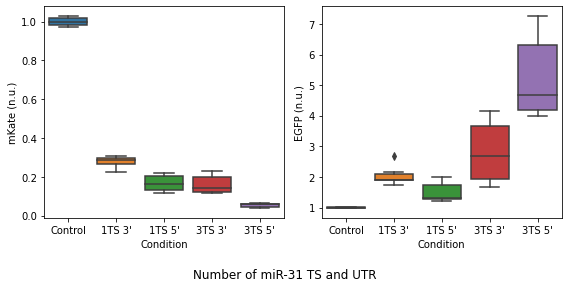

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

# Boxplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
fs = sns.boxplot(x='Condition', y='miRNA sensor', data=norm_df, ax=ax[0])
fs.set_ylabel('mKate (n.u.)')
fm = sns.boxplot(x='Condition', y='Capacity monitor', data=norm_df, ax=ax[1])
fm.set_ylabel('EGFP (n.u.)')
fig.supxlabel('Number of miR-31 TS and UTR')
fig.tight_layout()

Violin plots

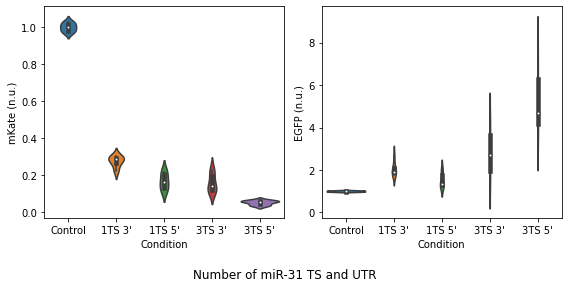

In [4]:
# Violin plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
fs = sns.violinplot(x='Condition', y='miRNA sensor', data=norm_df, ax=ax[0])
fs.set_ylabel('mKate (n.u.)')
fm = sns.violinplot(x='Condition', y='Capacity monitor', data=norm_df, ax=ax[1])
fm.set_ylabel('EGFP (n.u.)')
fig.supxlabel('Number of miR-31 TS and UTR')
fig.tight_layout()

Strip plots

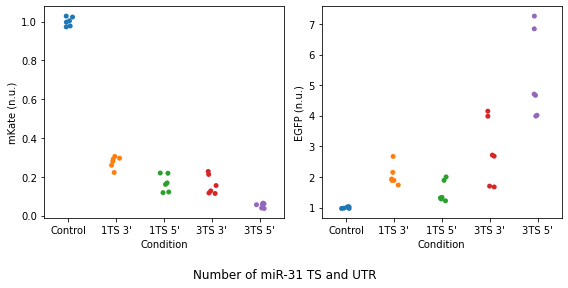

In [5]:
# Strip plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
fs = sns.stripplot(x='Condition', y='miRNA sensor', data=norm_df, ax=ax[0])
fs.set_ylabel('mKate (n.u.)')
fm = sns.stripplot(x='Condition', y='Capacity monitor', data=norm_df, ax=ax[1])
fm.set_ylabel('EGFP (n.u.)')
fig.supxlabel('Number of miR-31 TS and UTR')
fig.tight_layout()

## Model fitting

### Loss function and model function

In [6]:
import numpy as np

def loss_func(params, *args):
    LAMBDA = 0.001 
    mKate, EGFP = model_func(params, args)
    loss = np.sum((y.flatten() - np.concatenate([mKate, EGFP])) ** 2) + np.sum(params ** 2) * LAMBDA
    return loss 

def model_func(params, args):
    a1, a2, b, c1, c2, beta_t, lambda_t_q, rho_c = params
    condition_list, x, y = args
    a2 = a2 * np.array([x[i][0] for i in range(len(x))])
    a2[3:] = b * a2[3:]
    flag_3p = np.array([x[i][1] for i in range(len(x))])
    rho_t = a1 / (beta_t + a2)
    rho_t_q = a1 * a2 / lambda_t_q / beta_t / (a2 + beta_t)
    mKate = c1 * (rho_t + rho_t_q * flag_3p) / (1 + rho_t + rho_t_q * flag_3p + rho_c)
    EGFP = c2 * rho_c / (1 + rho_t + rho_t_q * flag_3p + rho_c)
    return mKate, EGFP

Run the global optimisation using differential evolution.

In [7]:
from scipy.optimize import differential_evolution

x = ((0, True), (1, True), (1, False), (1, True), (1, False))
y = np.array([avg_norm_df['miRNA sensor'], avg_norm_df['Capacity monitor']])
data = (condition_list[:], x[:], y[:, :])
bounds = [(1e-6, 1e+6), (1e-6, 1e+6), (1., 1e+6),(1e-6, 1e+6), (1e-6, 1e+6), (1e-6, 1e+6), (1., 1e+6), (1e-6, 1e+6)]

result = differential_evolution(loss_func, bounds, args=data, strategy='best1bin')#, maxiter=400, popsize=200, tol=1e-3, mutation=(0.5, 1.9), recombination=0.5, atol=1e-6)
params = {
    'a1' : result.x[0],
    'a2' : result.x[1], 
    'b' : result.x[2],
    'c1' : result.x[3],
    'c2' : result.x[4],
    'beta_t' : result.x[5],
    'lamda_t_q' : result.x[6],
    'rho_c' : result.x[7]
}
display(pd.DataFrame.from_dict([params]))

,a1,a2,b,c1,c2,beta_t,lamda_t_q,rho_c
0,0.464104,0.015148,10.384653,0.545777,9.341504,0.012219,5.340393,4.63109


Simulate the model using the identified model parameters.

In [8]:
mKate, EGFP = model_func(list(params.values()), data)

## Supplementary Fig. S3

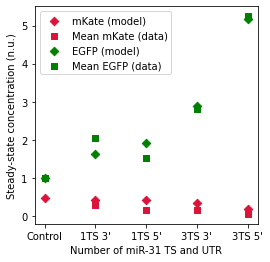

In [9]:
from matplotlib import pyplot as plt

x_span = range(len(x))

plt.figure(figsize=(4, 4))
plt.scatter(x_span, mKate, color='crimson', marker='D')
plt.scatter(x_span, y[0, :], color='crimson', marker='s')
plt.scatter(x_span, EGFP, color='green', marker='D')
plt.scatter(x_span, y[1, :], color='green', marker='s')
plt.legend(['mKate (model)', 'Mean mKate (data)', 'EGFP (model)', 'Mean EGFP (data)'])
plt.xticks(x_span, data[0])
plt.xlabel('Number of miR-31 TS and UTR')
plt.ylabel('Steady-state concentration (n.u.)')
plt.savefig(os.path.join(imgs_path, 'FigS3.pdf'), format='pdf')
plt.show()

## Identification of ${\lambda_T}^Q$

Calculate the distributions of the model parameters.

In [ ]:
from tqdm import tqdm

NUM_STEPS = 5000

params_list = list()
for _ in tqdm(range(NUM_STEPS)):
    tmp_result = differential_evolution(loss_func, bounds, args=data, strategy='best1bin')
    params_list.append({
        'a1' : tmp_result.x[0],
        'a2' : tmp_result.x[1], 
        'b' : tmp_result.x[2],
        'c1' : tmp_result.x[3],
        'c2' : tmp_result.x[4],
        'beta_t' : tmp_result.x[5],
        'lamda_t_q' : tmp_result.x[6],
        'rho_c' : tmp_result.x[7]
    })

params_df = pd.DataFrame(params_list)
params_df.to_csv(os.path.join(data_path, 'output', 'params_distro.csv'))
display(params_df)

##  Supplementary Fig. S6

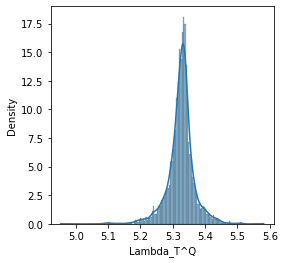

In [10]:
params_df = pd.read_csv(os.path.join(data_path, 'output', 'params_distro.csv'), index_col=0) 

plt.figure(figsize=[4, 4])
sns.histplot(x='lamda_t_q', data=params_df, stat='density', kde=True, log_scale=False)
plt.xlabel('Lambda_T^Q')
plt.savefig(os.path.join(imgs_path, 'FigS6.pdf'), format='pdf')

The mean calculated on the distribution of ${\kappa_t}^+$ is

In [11]:
print(params_df['lamda_t_q'].mean())

5.32531000236288
